# <center> Кластеризация подростков

Большинство подростков активно общаются в социальных сетях. Многие из них также совершают покупки в интернете, что, естественно, вызывает интерес у рекламодателей. Маркетологи различных компаний стремятся выделять сегменты подростков с похожими интересами, чтобы давать более персонализированную рекламу и привлекать только тех подростков, которые могут стать их потенциальными клиентами. Например, магазину спортивной одежды интересно давать рекламу для девушек и юношей, которые относятся к сегменту интересующихся спортом.

В данной работе мы решим задачу сегментации подростков по их интересам. [Набор данных](https://lms-cdn.skillfactory.ru/assets/courseware/v1/ecf4013386fbfff89f564dc426160a88/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/snsdata.zip) представляет собой случайную выборку из 30 000 американских старшеклассников, у которых в 2006 году были профили в одной известной социальной сети, название которой авторы датасета не раскрывают в целях сохранения анонимности. Данные были отобраны равномерно для четырёх разных возрастов (предполагаемый год окончания школы — 2006–2009).

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import matplotlib.pyplot as plt

## Загрузка и подготовка данных


In [2]:
snsdf = pd.read_csv('data/snsdata.zip')
snsdf.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Признаки в данных
- gradyear — год выпуска;
- gender — пол;
- age — возраст;
- friends — число друзей в социальной сети;
- basketball, football, soccer, softball, volleyball, swimming, cheerleading, baseball, tennis, sports, cute, sex, sexy, hot, kissed, dance, band, marching, music, rock, god, church, jesus, bible, hair, dress, blonde, mall, shopping, clothes, hollister, abercrombie, die, death, drunk, drugs (переменные с пятой по сороковую) — частота встречаемости соответствующих слов в сообщениях подростка.

### Обрезка данных

Мы будем реализовывать алгоритм только на признаках, которые заключают в себе ключевые слова, встречающиеся в сообщениях подростка. Поэтому удалим все остальные признаки.

In [3]:
snsdf.drop(['gradyear', 'gender', 'age', 'friends'], axis=1, inplace=True)
snsdf.shape

(30000, 36)

### Стандартизация

Теперь нормализуем данные с помощью StandardScaler.

In [4]:
X = snsdf.values
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)


## Моделирование

### k-means

Реализуем алгоритм k-means c девятью кластерами.

In [5]:
# Инициализация
km_model = KMeans(
    n_clusters=9,
    random_state=42,
    n_init=10
)
# Обучение
km_model.fit(X_norm)
# Вывод инерции
print(f'Инерция при 9 кластерах: {round(km_model.inertia_, 2)}')


Инерция при 9 кластерах: 856276.7


Посмотрим, сколько подростков относится к каждому кластеру.

In [6]:
# Добавим признак с номерами присвоенных кластеров
snsdf.loc[:, 'km_label'] = km_model.labels_
# Подсчитаем численность населения кластеров
snsdf.km_label.value_counts()

km_label
1    19599
2     4284
0     2201
4      941
3      902
5      851
8      754
7      467
6        1
Name: count, dtype: int64

Для каждого кластера составим топ-10 самых частых слов, назовём их ключевыми. Для этого сгруппируем данные по кластерам, в каждом кластере вычислим среднее по каждому признаку, отсортируем данные по убыванию и выделим первые 10 строк.

Найдем среди ключевых слов те, которые характерны для каждого кластера, то есть встречаются в каждом из них.

In [7]:
top_list = []
for label, group in snsdf.groupby('km_label'):
    means = group.iloc[:,:-1].mean().sort_values(ascending=False)
    top_10 = list(means.head(10).index)
    print(f'Топ 10 слов кластера №{label}: {top_10}')
    top_list.append(set(top_10))

print(f'Вероятные общие интересы: {set.intersection(*top_list)}')

Топ 10 слов кластера №0: ['basketball', 'softball', 'football', 'volleyball', 'baseball', 'music', 'sports', 'god', 'hair', 'dance']
Топ 10 слов кластера №1: ['music', 'god', 'dance', 'hair', 'shopping', 'band', 'rock', 'cute', 'church', 'die']
Топ 10 слов кластера №2: ['dance', 'music', 'shopping', 'cute', 'hair', 'mall', 'god', 'church', 'clothes', 'hot']
Топ 10 слов кластера №3: ['soccer', 'tennis', 'music', 'shopping', 'god', 'hair', 'dance', 'basketball', 'football', 'cute']
Топ 10 слов кластера №4: ['hair', 'sex', 'music', 'kissed', 'die', 'rock', 'drugs', 'god', 'dance', 'drunk']
Топ 10 слов кластера №5: ['hollister', 'abercrombie', 'shopping', 'music', 'hair', 'dance', 'mall', 'cute', 'god', 'clothes']
Топ 10 слов кластера №6: ['blonde', 'sex', 'hair', 'god', 'drunk', 'death', 'die', 'football', 'dress', 'rock']
Топ 10 слов кластера №7: ['god', 'church', 'jesus', 'music', 'bible', 'hair', 'dance', 'band', 'shopping', 'die']
Топ 10 слов кластера №8: ['band', 'marching', 'music',

Похоже, всем подросткам было свойственно не в последнюю очередь заботиться о волосах (с разным приоритетом от кластера к кластеру). И, вероятно, все подростки, за исключением тех, что из седьмого, имели обыкновение нарушать третюю завоведь Моисея: поминали господа всуе.

В кластере 6 всего один подросток, и это может свидетельствовать о плохой кластеризации.

### Оптимизация k-means

1. Попробуем применить разные методы для нахождения числа кластеров. Будем выбирать количество кластеров из диапазона от 3 до 9.
   
   Для начала применим метод локтя.

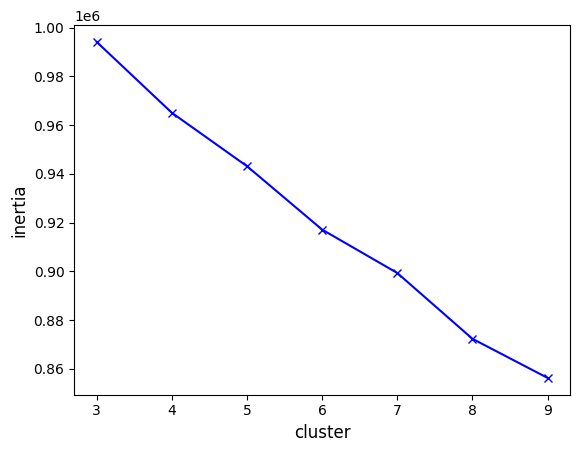

In [8]:
# Напишем функцию для прогона алгоритма по заданному
# числу кластеров и получения значения инерции
def get_inertia(cluster_num, X_norm):
    k_means =  KMeans(
        n_clusters=cluster_num,
        n_init=10,
        random_state=42
    )
    k_means.fit(X_norm)
    inertia = k_means.inertia_
    return inertia

# Создадим список для сбора значений инерции
inertia = []
# Пройдемся циклом по интервалу
for cluster_num in range(3, 10):
    inertia.append(get_inertia(cluster_num, X_norm))

# Нарисуем графику
plt.xlabel("cluster", fontsize=12)
plt.ylabel("inertia", fontsize=12)
plt.plot([i for i in range(3, 10)], inertia, 'xb-');

В нашем случае метод локтя, к сожалению, малоинформативен.

2. Теперь попробуем подобрать оптимальное количество кластеров с помощью коэффициента силуэта.

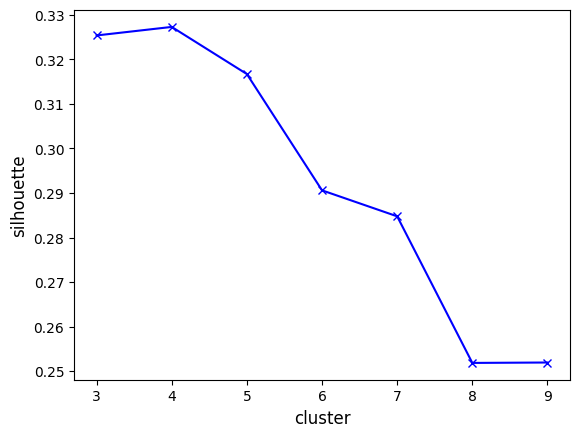

In [9]:
# Напишем функцию для прогона алгоритма по заданному
# числу кластеров и получения значения коэффициента силуэта
def get_silhouette(cluster_num, X_norm):
    k_means =  KMeans(
        n_clusters=cluster_num,
        n_init=10,
        random_state=42
    )
    k_means.fit(X_norm)
    silhouette = silhouette_score(X_norm, k_means.labels_, metric='euclidean')
    return silhouette

# Создадим список для сбора значений коэффициента силуэта
silhouettes = []
# Пройдемся циклом по интервалу
for i in range(3, 10):
    silhouettes.append(get_silhouette(i, X_norm))

# Нарисуем графику
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(3, 10)], silhouettes, 'xb-');

Похоже, нам стоит воспользоваться результатом, полученным с помощью коэффициента силуэта.

Реализуем сегментацию подростков на выбранном количестве кластеров.

In [10]:
# Инициализация
km_model = KMeans(
    n_clusters=4,
    n_init=10,
    random_state=42
)
# Обучение
km_model.fit(X_norm)
# Вывод инерции
print(f'Инерция при 4 кластерах: {round(km_model.inertia_, 2)}')

Инерция при 4 кластерах: 965041.28


Значение инерции возросло. Разумеется, чем меньше эта величина, тем лучше. Однако здесь есть большая проблема: минимальное значение этой функции будет достигаться тогда, когда количество кластеров будет равняться количеству объектов (т. е. каждый кластер будет состоять из одной точки и расстояния будут нулевыми). Это уже будет ситуация переобучения, так как алгоритм чересчур сильно подстроится под данные.

In [11]:
np.unique(km_model.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([22855,  6029,  1115,     1], dtype=int64))

В кластерe 3 оказался всего один человек. Давайте узнаем, тот же ли это подросток, что ранее в одиночестве оказался в кластере 6.

In [12]:
snsdf.loc[:, 'km_label_opt'] = km_model.labels_
snsdf[snsdf['km_label_opt'] == 3]['km_label']


14187    6
Name: km_label, dtype: int32

Да, так и есть.

3. Попробуем подобрать другое число кластеров с помощью индекса Калински-Харабаса.

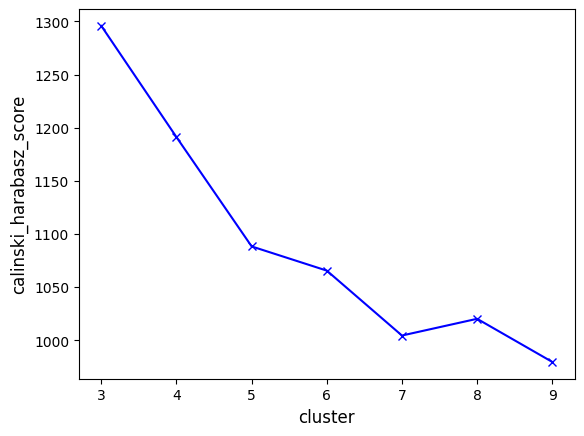

In [13]:
# Напишем функцию для прогона алгоритма по заданному
# числу кластеров и получения значения индекса Калински-Харабаса
def get_calinski_harabasz(cluster_num, X_norm):
    km_model = KMeans(
        n_clusters=cluster_num,
        n_init=10,
        random_state=42
    )
    km_model.fit(X_norm)
    calinski_harabasz = calinski_harabasz_score(X_norm, km_model.labels_)
    return calinski_harabasz

# Создадим список для сбора значений индекса Калински-Харабаса
calinski_harabasz = []
# Пройдемся циклом по интервалу
for i in range(3, 10):
    calinski_harabasz.append(get_calinski_harabasz(i, X_norm))

# Нарисуем графику
plt.xlabel("cluster", fontsize=12)
plt.ylabel("calinski_harabasz_score", fontsize=12)
plt.plot([i for i in range(3, 10)], calinski_harabasz, 'xb-');

Более высокое значение индекса здесь означает, что кластеры плотные (т. е. объекты внутри них находятся близко друг к другу) и хорошо разделены. Наиболее оптимальное число кластеров по индексу Калински-Харабаса поэтому — 3.

In [14]:
# Инициализация
km_model = KMeans(
    n_clusters=3,
    n_init=10,
    random_state=42
)
# Обучение
km_model.fit(X_norm)
# Вывод инерции
print(f'Инерция при 3 кластерах: {round(km_model.inertia_, 2)}')
print(np.unique(km_model.labels_, return_counts=True))

Инерция при 3 кластерах: 994114.72
(array([0, 1, 2]), array([22925,  5942,  1133], dtype=int64))


Выведем десяток самых частоупотребляемых слов для получившихся кластеров.

In [15]:
# Добавим признак с номерами присвоенных кластеров
snsdf.loc[:, 'km_label_ch'] = km_model.labels_
top_list = []
for label, group in snsdf.groupby('km_label_ch'):
    means = group.iloc[:,:-3].mean().sort_values(ascending=False)
    top_10 = list(means.head(10).index)
    print(f'Топ 10 слов кластера №{label}: {top_10}')
    top_list.append(set(top_10))

print(f'Вероятные общие интересы: {set.intersection(*top_list)}')

Топ 10 слов кластера №0: ['music', 'god', 'dance', 'band', 'hair', 'shopping', 'cute', 'rock', 'soccer', 'football']
Топ 10 слов кластера №1: ['music', 'dance', 'shopping', 'god', 'cute', 'hair', 'church', 'basketball', 'mall', 'football']
Топ 10 слов кластера №2: ['hair', 'sex', 'music', 'kissed', 'die', 'rock', 'god', 'band', 'dance', 'drugs']
Вероятные общие интересы: {'god', 'dance', 'music', 'hair'}


4. Попробуем также расчитать индекс Дэвиса-Болдина в зависимости от числа кластеров.

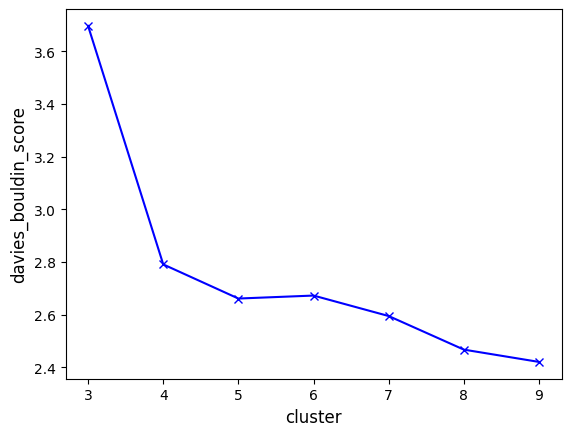

In [16]:
# Напишем функцию для прогона алгоритма по заданному
# числу кластеров и получения значения индекса Дэвиса-Болдина
def get_davies_bouldin(cluster_num, X_norm):
    km_model = KMeans(
        n_clusters=cluster_num,
        n_init=10,
        random_state=42
    )
    predictions = km_model.fit_predict(X_norm)
    davies_bouldin = davies_bouldin_score(X_norm, predictions)
    return davies_bouldin

# Создадим список для сбора значений индекса Дэвиса-Болдина
davies_bouldin = []
# Пройдемся циклом по интервалу
for i in range(3, 10):
    davies_bouldin.append(get_davies_bouldin(i, X_norm))

# Нарисуем графику
plt.xlabel("cluster", fontsize=12)
plt.ylabel("davies_bouldin_score", fontsize=12)
plt.plot([i for i in range(3, 10)], davies_bouldin, 'xb-');

Индекс Дэвиса-Болдина показывает среднюю "схожесть" между кластерами, и 0 — это минимально возможное значение. Разумеется, так как мы хотим, чтобы кластеры были максимально различными (т. е. имели низкую схожесть), мы должны пытаться достичь как можно более маленького значения.

Ситуацию с 9 кластерами мы уже рассматривали, возьмем на этот раз случай с 8.

In [17]:
# Инициализация
km_model = KMeans(
    n_clusters=8,
    n_init=10,
    random_state=42
)
# Обучение
km_model.fit(X_norm)
# Вывод инерции
print(f'Инерция при 8 кластерах: {round(km_model.inertia_, 2)}')
print(np.unique(km_model.labels_, return_counts=True))

Инерция при 8 кластерах: 872318.48
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([  583, 20000,   957,     1,   585,  2445,  4566,   863],
      dtype=int64))


И снова у нас имеется кластер с одним человеком. Пожалуй, на этом нам стоит перейти уже к рассмотрению другого алгоритма.

### EM

Итак, с k-means мы поработали — теперь перейдём к EM-алгоритму.

Реализуем EM-алгоритм (GaussianMixture) также для 9 кластеров.

In [18]:
# Инициализация
gm_model = GaussianMixture(
    n_components=9,
    random_state=42
)
# Предсказание кластера
predictions = gm_model.fit_predict(X_norm)
# Сводка по числу кластеров и их составу
np.unique(predictions, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([ 5669, 17261,  1263,  1658,   258,   804,     1,   626,  2460],
       dtype=int64))

У нас снова есть кластер с одиночкой. Однако мы все же произведем анализ популярных слов.

In [19]:
snsdf.loc[:, 'gm_label'] = predictions
top_list = []
for label, group in snsdf.groupby('gm_label'):
    means = group.iloc[:,:-4].mean().sort_values(ascending=False)
    top_10 = set(means.head(10).index)
    print(f'Топ 10 слов кластера №{label} : {top_10}')
    top_list.append(top_10)

print(f'Вероятные общие интересы: {set.intersection(*top_list)}')

Топ 10 слов кластера №0 : {'volleyball', 'god', 'church', 'shopping', 'football', 'softball', 'basketball', 'soccer', 'music', 'dance'}
Топ 10 слов кластера №1 : {'god', 'cute', 'shopping', 'hair', 'football', 'basketball', 'mall', 'rock', 'music', 'dance'}
Топ 10 слов кластера №2 : {'sexy', 'cute', 'god', 'shopping', 'sex', 'hair', 'mall', 'rock', 'music', 'dance'}
Топ 10 слов кластера №3 : {'cute', 'abercrombie', 'shopping', 'hollister', 'hair', 'mall', 'tennis', 'soccer', 'music', 'dance'}
Топ 10 слов кластера №4 : {'god', 'die', 'sex', 'hair', 'basketball', 'kissed', 'band', 'rock', 'music', 'dance'}
Топ 10 слов кластера №5 : {'cute', 'abercrombie', 'rock', 'shopping', 'sex', 'softball', 'hair', 'soccer', 'music', 'dance'}
Топ 10 слов кластера №6 : {'death', 'god', 'die', 'hair', 'sex', 'football', 'drunk', 'dress', 'blonde', 'rock'}
Топ 10 слов кластера №7 : {'god', 'church', 'die', 'bible', 'shopping', 'hair', 'jesus', 'band', 'music', 'dance'}
Топ 10 слов кластера №8 : {'god', '

В этот раз в топах всех кластеров нет ни одного пересечения.

### Оптимизация EM

Т.к. EM-алгоритм оперирует не расстояниями, а вероятностями, метод локтя применить мы не сможем. 

1. Поэтому рассмотрим сразу применение коэффициента силуэта.

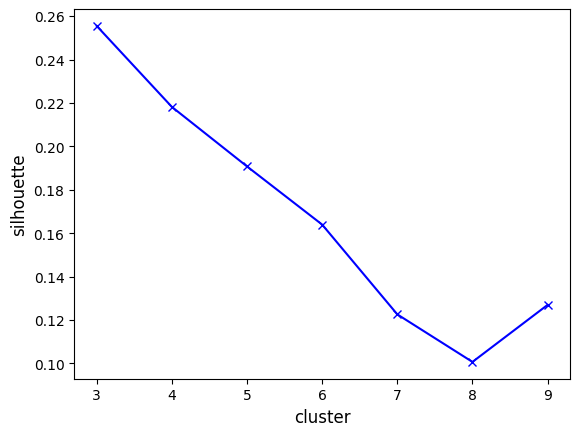

In [20]:
# Напишем функцию для прогона алгоритма по заданному
# числу кластеров и получения значения коэффициента силуэта
def get_silhouette_gm(cluster_num, X_norm):
    gm_model = GaussianMixture(
    n_components=cluster_num,
    random_state=42
    )
    predictions = gm_model.fit_predict(X_norm)
    silhouette = silhouette_score(X_norm, predictions, metric='euclidean')
    return silhouette

# Создадим список для сбора значений коэффициента силуэта
silhouettes_gm = []
# Пройдемся циклом по интервалу
for i in range(3, 10):
    silhouettes_gm.append(get_silhouette_gm(i, X_norm))

# Нарисуем графику
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(3, 10)], silhouettes_gm, 'xb-');

In [21]:
# Инициализация
gm_model = GaussianMixture(
    n_components=3,
    random_state=42
)
# Предсказание кластера
predictions = gm_model.fit_predict(X_norm)
# Сводка по числу кластеров и их составу
np.unique(predictions, return_counts=True)

(array([0, 1, 2], dtype=int64), array([20670,  2874,  6456], dtype=int64))

In [22]:
snsdf.loc[:, 'gm_label_opt'] = predictions
top_list = []
for label, group in snsdf.groupby('gm_label_opt'):
    means = group.iloc[:,:-5].mean().sort_values(ascending=False)
    top_10 = set(means.head(10).index)
    print(f'Топ 10 слов кластера №{label} : {top_10}')
    top_list.append(top_10)

print(f'Вероятные общие интересы: {set.intersection(*top_list)}')

Топ 10 слов кластера №0 : {'god', 'cute', 'shopping', 'hair', 'football', 'basketball', 'mall', 'band', 'music', 'dance'}
Топ 10 слов кластера №1 : {'god', 'die', 'sex', 'hair', 'drugs', 'kissed', 'band', 'rock', 'music', 'dance'}
Топ 10 слов кластера №2 : {'god', 'cute', 'church', 'shopping', 'hair', 'softball', 'basketball', 'soccer', 'music', 'dance'}
Вероятные общие интересы: {'god', 'dance', 'music', 'hair'}


Результат хоть и довольно похож на тот случай, в котором мы получали три кластера с помощью k-means, но их состав на этот раз иной, хоть мы и наблюдаем те же самые пересечния между топами.

2. Рассмотрим применение индекса Дэвиса-Болдина.

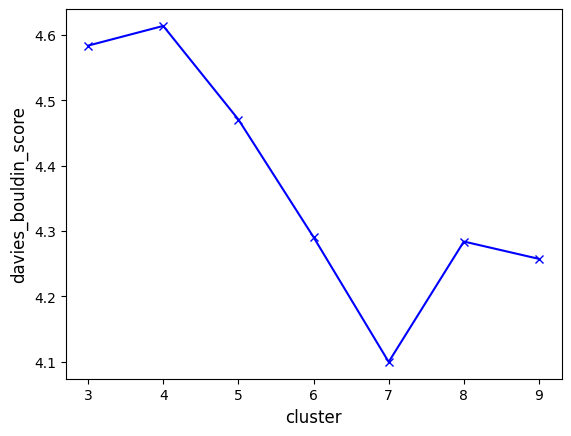

In [23]:
# Напишем функцию для прогона алгоритма по заданному
# числу кластеров и получения значения индекса Дэвиса-Болдина
def get_davies_bouldin_gm(cluster_num, X_norm):
    gm_model = GaussianMixture(
        n_components=cluster_num,
        random_state=42
    )
    predictions = gm_model.fit_predict(X_norm)
    davies_bouldin = davies_bouldin_score(X_norm, predictions)
    return davies_bouldin

# Создадим список для сбора значений индекса Дэвиса-Болдина
davies_bouldin_gm = []
# Пройдемся циклом по интервалу
for i in range(3, 10):
    davies_bouldin_gm.append(get_davies_bouldin_gm(i, X_norm))

# Нарисуем графику
plt.xlabel("cluster", fontsize=12)
plt.ylabel("davies_bouldin_score", fontsize=12)
plt.plot([i for i in range(3, 10)], davies_bouldin_gm, 'xb-');

Индекс Дэвиса-Болдина рекомендует нам взять число кластеров — 7.

In [24]:
# Инициализация
gm_model = GaussianMixture(
    n_components=7,
    random_state=42
)
# Предсказание кластера
predictions = gm_model.fit_predict(X_norm)
# Сводка по числу кластеров и их составу
np.unique(predictions, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int64),
 array([16458,   346,  5645,  2564,   637,  2874,  1476], dtype=int64))

In [25]:
snsdf.loc[:, 'gm_label_db'] = predictions
top_list = []
for label, group in snsdf.groupby('gm_label_db'):
    means = group.iloc[:,:-6].mean().sort_values(ascending=False)
    top_10 = set(means.head(10).index)
    print(f'Топ 10 слов кластера №{label} : {top_10}')
    top_list.append(top_10)

print(f'Вероятные общие интересы: {set.intersection(*top_list)}')

Топ 10 слов кластера №0 : {'god', 'cute', 'shopping', 'hair', 'football', 'mall', 'band', 'rock', 'music', 'dance'}
Топ 10 слов кластера №1 : {'god', 'cute', 'sex', 'hair', 'blonde', 'kissed', 'band', 'rock', 'music', 'dance'}
Топ 10 слов кластера №2 : {'volleyball', 'god', 'church', 'shopping', 'football', 'softball', 'basketball', 'soccer', 'music', 'dance'}
Топ 10 слов кластера №3 : {'cute', 'god', 'shopping', 'hair', 'football', 'basketball', 'mall', 'cheerleading', 'music', 'dance'}
Топ 10 слов кластера №4 : {'god', 'church', 'die', 'bible', 'shopping', 'hair', 'jesus', 'band', 'music', 'dance'}
Топ 10 слов кластера №5 : {'god', 'cute', 'die', 'sex', 'hair', 'kissed', 'band', 'rock', 'music', 'dance'}
Топ 10 слов кластера №6 : {'cute', 'abercrombie', 'god', 'shopping', 'hollister', 'hair', 'mall', 'soccer', 'music', 'dance'}
Вероятные общие интересы: {'god', 'music', 'dance'}


Мы получили кластеры без одиночек и, вероятно, довольно разные по интересам.

3. Но мы еще не рассмотрели вариант с индексом Калински-Харабаса.

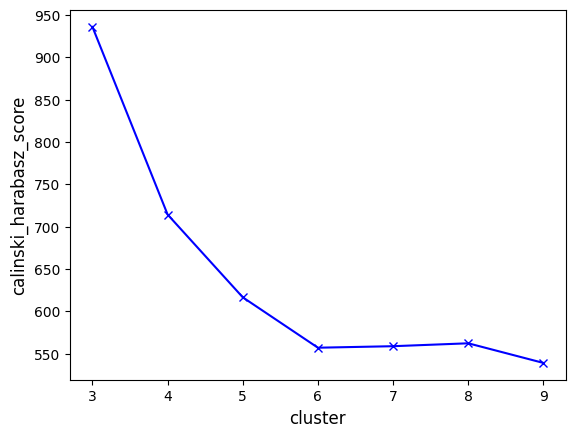

In [26]:
# Напишем функцию для прогона алгоритма по заданному
# числу кластеров и получения значения индекса Калински-Харабаса
def get_calinski_harabasz_gm(cluster_num, X_norm):
    gm_model = GaussianMixture(
        n_components=cluster_num,
        random_state=42
    )
    predictions = gm_model.fit_predict(X_norm)
    calinski_harabasz = calinski_harabasz_score(X_norm, predictions)
    return calinski_harabasz

# Создадим список для сбора значений индекса Калински-Харабаса
calinski_harabasz_gm = []
# Пройдемся циклом по интервалу
for i in range(3, 10):
    calinski_harabasz_gm.append(get_calinski_harabasz_gm(i, X_norm))

# Нарисуем графику
plt.xlabel("cluster", fontsize=12)
plt.ylabel("calinski_harabasz_score", fontsize=12)
plt.plot([i for i in range(3, 10)], calinski_harabasz_gm, 'xb-');

Здесь нам снова предлагается использовать три кластера, а такой случай мы уже рассмотрели выше.

## Итог

Отметим, наконец, что некоторую кластеризацию мы произвести смогли, однако мы никогда не сможем до конца убедиться в том, что она действительно была объективна. И дело не в том, что в нашем кейсе фигурируют довольно старые данные и сегментирующая модель, обученная на них, мало кому нынче может быть полезна. Загвоздка в том, я полагаю, что успешность кластеризации легче всего достовернее оценить путем непосредственного приложения модели к практике.

Использованные нами метрики помогают лишь оценить кластеризацию изнутри. Они действительно помогают нам сделать сегментацию качественнее, но мы остаемся оторванными от реальности. Сильнее всего это касается, наверное, именно нашего случая — когда у нас нет и размеченных данных.